In [ ]:
using MagneticLaplacianSparsifier
using Graphs, MetaGraphs, Random, IterTools, LinearAlgebra, GraphPlot, Arpack, Plots, SparseArrays
using Statistics
using Measures
using StatsBase

using GraphIO 
using ParserCombinator 

### Sampling times SFs and STs

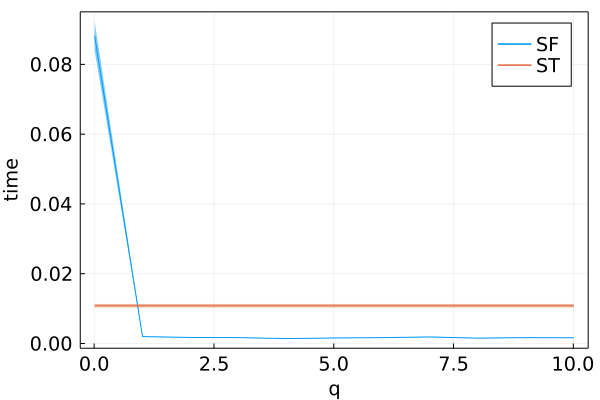

In [2]:
rng = Random.default_rng()

# number of runs per random graph
n_rep = 1000

# parameters of Barbell graph
n_com = 250
n = 2*n_com
η = 0.
noise = 0
planted_score = randperm(rng,n)

meta_g = gen_graph_cliques(rng,n_com,noise,η;planted_score)
for e in edges(meta_g)
    set_prop!(meta_g, e, :angle, 0.0)
end

# range of q values
q_range = 0.01 : 1 : 10.1
nb_q = length(q_range) 

# initialization
av_time_sf = zeros(nb_q,1)
median_time_sf = zeros(nb_q,1)
std_time_sf = zeros(nb_q,1)
mean_nb_roots = zeros(nb_q,1)
std_nb_roots = zeros(nb_q,1)

for i_q = 1:nb_q
    time_sf_tp = zeros(n_rep,1)
    nb_roots_tp = zeros(n_rep,1)

    q = q_range[i_q]

    for i_rep = 1:n_rep
        vec_sf = @timed multi_type_spanning_forest(rng, meta_g, q)
        sf = vec_sf[1]
        # get the roots
        roots = get_prop(sf,:roots)
        # nb_roots
        nb_roots_tp[i_rep] = length(roots)
        # timing
        t_sf = vec_sf[2]
        time_sf_tp[i_rep] = t_sf
    end

    # averaging
    mean_nb_roots[i_q] = mean(nb_roots_tp)
    std_nb_roots[i_q] = std(nb_roots_tp)

    av_time_sf[i_q] = mean(time_sf_tp)
    median_time_sf[i_q] = median(time_sf_tp)
    std_time_sf[i_q] = std(time_sf_tp)
end

# sample STs

# parameters
absorbing_node = true
ust = true

# initialization
time_ust_tp = zeros(n_rep,1)
for i_rep = 1:n_rep
    q_ust = 0
    vec_ust = @timed multi_type_spanning_forest(rng, meta_g, q_ust;absorbing_node, ust)
    # timing
    t_ust = vec_ust[2]
    time_ust_tp[i_rep] = t_ust
end

# averaging
av_time_ust = mean(time_ust_tp)*ones(size(q_range))
median_time_ust = median(time_ust_tp)*ones(size(q_range))
std_time_ust = std(time_ust_tp)*ones(size(q_range))

# standard error of the mean
SEM_sf = std_time_sf/sqrt(n_rep)
SEM_ust = std_time_ust/sqrt(n_rep)

# plotting timings
plt = plot(q_range, av_time_sf, ribbon = SEM_sf, labels = "SF")
plot!(q_range, av_time_ust, ribbon = SEM_ust, labels = "ST",  
xtickfont=font(13),
ytickfont=font(13),
guidefont=font(13),
legendfont=font(13),
framestyle=:box,)
xlabel!("q")
ylabel!("time")

display(plt)

# saving figure
foldername = "figures/"
name = "barbell_sf_st_timing.pdf"
savefig(foldername*name)

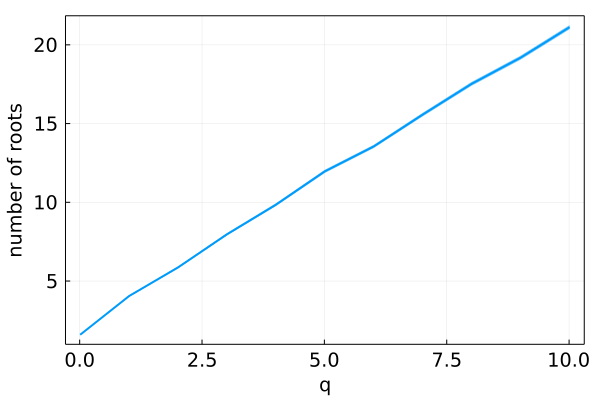

In [3]:
# plotting number of roots vs q
plt = plot(q_range,mean_nb_roots,  ribbon = std_nb_roots/sqrt(n_rep),      
markersize=5,
linewidth=2,
markerstrokewidth=2,
xtickfont=font(13),
ytickfont=font(13),
guidefont=font(13),
legendfont=font(13),
framestyle=:box,
legend = false,
margins=0.1 * 2cm)

xlabel!("q")
ylabel!("number of roots")

display(plt)

# saving figure
foldername = "figures/"
name = "barbell_sf_st_nb_roots.pdf"
savefig(foldername*name)

### Sampling CRSFs vs STs in a MUN Barbell graph

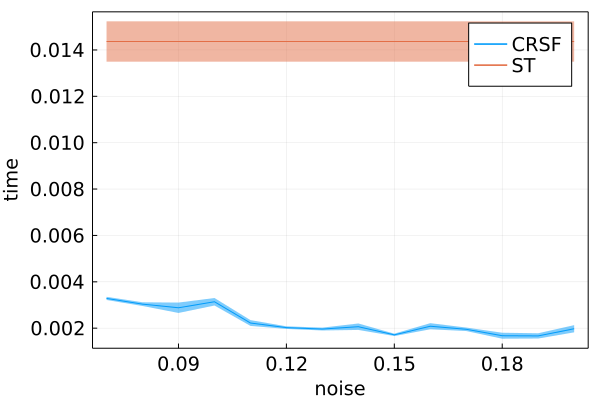

In [10]:
rng = Random.default_rng();

# number of runs per random graph
n_rep = 2000

# regularization parameter
q = 0

# parameters of Barbell graph
n_com = 250
n = 2*n_com

# planted ranking score
planted_score = randperm(rng,n)

# range of values for uniform noise
noise_range = 0.07 : 0.01 : 0.2
nb = length(noise_range) 
η = 0. # no outlier noisy edge only uniform noise


# initialization
av_time_crsf = zeros(nb,1)
median_time_crsf = zeros(nb,1)
std_time_crsf = zeros(nb,1)

mean_nb_cycles = zeros(nb,1)
std_nb_cycles = zeros(nb,1)

# sample CRSFs
# loop over noise values
for i_noise = 1:nb

    # temporary arrays
    time_crsf_tp = zeros(n_rep,1)
    nb_cycles_tp = zeros(n_rep,1)

    # noisy Barbell graph
    noise = noise_range[i_noise]
    meta_g = gen_graph_cliques(rng,n_com,noise,η;planted_score)

    for i_rep = 1:n_rep
        # sample
        vec_crsf = @timed multi_type_spanning_forest(rng, meta_g, q)
        crsf = vec_crsf[1]

        # find list of cycles 
        cycles = get_prop(crsf,:cycle_nodes)
        # number of cycles
        nb_cycles_tp[i_rep] = length(cycles)

        # time to sample a crsf
        t_crsf = vec_crsf[2]
        time_crsf_tp[i_rep] = t_crsf
    end
    
    mean_nb_cycles[i_noise] = mean(nb_cycles_tp)
    std_nb_cycles[i_noise] = std(nb_cycles_tp)

    av_time_crsf[i_noise] = mean(time_crsf_tp)
    median_time_crsf[i_noise] = median(time_crsf_tp)
    std_time_crsf[i_noise] = std(time_crsf_tp)
    
end

# sample STs

# parameters
absorbing_node = true
ust = true

# initialization
time_ust_tp = zeros(n_rep,1)
# deterministic Barbell
noise = 0
η = 0
meta_g = gen_graph_cliques(rng,n_com,noise,η;planted_score)

# repeated sampling
for i_rep = 1:n_rep
    # sampling spanning tree
    q_ust = 0
    vec_ust = @timed multi_type_spanning_forest(rng, meta_g, q_ust;absorbing_node, ust)
    # sampling time
    t_ust = vec_ust[2]
    time_ust_tp[i_rep] = t_ust
    
end

# averaging
av_time_ust = mean(time_ust_tp)*ones(size(noise_range))
median_time_ust = median(time_ust_tp)*ones(size(noise_range))
std_time_ust = std(time_ust_tp)*ones(size(noise_range))

# standard error of the mean
SEM_crsf = std_time_crsf/sqrt(n_rep)
SEM_ust = std_time_ust/sqrt(n_rep)

# plotting
plt = plot(noise_range, av_time_crsf, ribbon = SEM_crsf, labels = "CRSF")
plot!(noise_range, av_time_ust, ribbon = SEM_ust, labels = "ST",  
xtickfont=font(13),
ytickfont=font(13),
guidefont=font(13),
legendfont=font(13),
framestyle=:box,)
xlabel!("noise")
ylabel!("time")

display(plt)

# saving figure
foldername = "figures/"
name = "barbell_crsf_st_timing.pdf"
savefig(foldername*name)


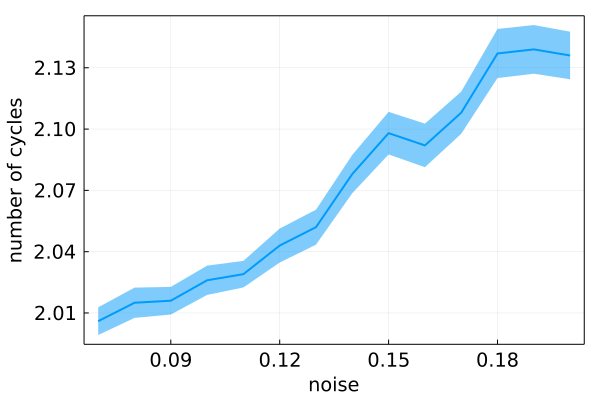

In [9]:
# plotting number of cycles
plt = plot(noise_range,mean_nb_cycles,
ribbon = std_nb_cycles/sqrt(n_rep),        
markerstrokecolor=:auto,
linewidth=2,
xtickfont=font(13),
ytickfont=font(13),
guidefont=font(13),
framestyle=:box, legend = false,
margins=0.1 * 2cm)

xlabel!("noise")
ylabel!("number of cycles")

display(plt)

# saving
foldername = "figures/"
name = "barbell_crsf_st_nb_cycles.pdf"
savefig(foldername*name)